Model Accuracy: 98.27%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1403
           1       0.99      0.98      0.99      2077
           2       0.96      0.83      0.89       106

    accuracy                           0.98      3586
   macro avg       0.97      0.94      0.95      3586
weighted avg       0.98      0.98      0.98      3586



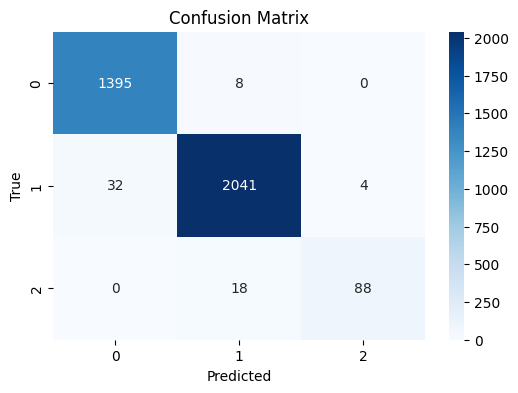

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

# Load the processed data
df = pd.read_csv('../data/processed_data.csv')

# Features and labels
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)']]
y = df['Driving_Category'].map({'Safe': 0, 'Moderate': 1, 'Aggressive': 2})  # Convert labels to numeric

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train a simpler RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model to a file
with open('../models/driving_behavior_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
